# WIDS Predict Hospital Fatality

**Table of Contents:**

1. Import Libriaries/packages
2. Explore Data
3. Preprocess data (missing values, collinearity (correlation), scale)
4. Model
5. Evaluate

In [1]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\samplesubmission.csv
./input\solution_template.csv
./input\training_v2.csv
./input\unlabeled.csv
./input\WiDS Datathon 2020 Dictionary.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder



# additional experiement packages
import missingno as msno

%matplotlib inline

## Load Data

In [20]:
# loading dataset 
training = pd.read_csv("./input/training_v2.csv")
solution_template = pd.read_csv("./input/solution_template.csv")
samplesubmission = pd.read_csv("./input/samplesubmission.csv")
unlabeled = pd.read_csv("./input/unlabeled.csv")
dictionary = pd.read_csv("./input/WiDS Datathon 2020 Dictionary.csv")

In [4]:
df = training_v2.copy()

In [5]:
training_v2.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [13]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [7]:
solution_template.head()

,encounter_id,hospital_death
0,2,NaN
1,5,NaN
2,7,NaN
3,8,NaN
4,10,NaN


In [8]:
samplesubmission.head()

,encounter_id,hospital_death
0,2,0.500
1,5,0.200
2,7,0.001


In [9]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [10]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


In [11]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


In [27]:
%%time

corr_matrix = training.corr().abs

Wall time: 7.29 s


In [15]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

AttributeError: 'function' object has no attribute 'where'

In [23]:
training_3 = training.copy()

In [24]:
training_3.drop(training_3.columns[training_3.apply(lambda col: col.isnull().sum() / training_3.shape[0] > 0.5)], axis = 1)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [28]:
training.dtypes.value_counts()

float64    170
object       8
int64        8
dtype: int64

In [29]:
training['patient_id'].nunique()

91713

In [32]:
training['age'].describe()

count    87485.000000
mean        62.309516
std         16.775119
min         16.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         89.000000
Name: age, dtype: float64

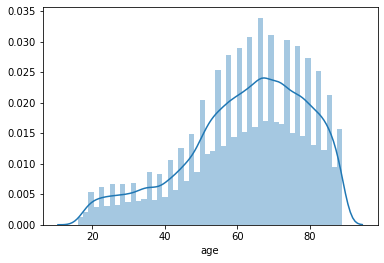

In [31]:
sns.distplot(training['age'].dropna())

## Missing values

Columnwise

Text(0, 0.5, 'count of fields')

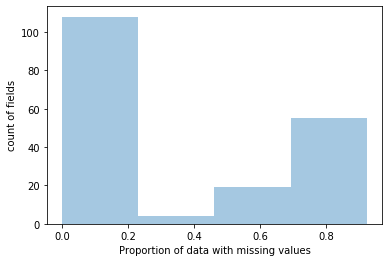

In [44]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False)

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Text(0, 0.5, 'count of fields')

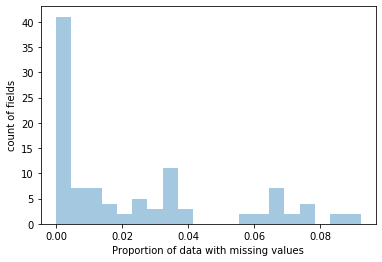

In [105]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Based on the plot below, we have decided to make the cut off for missing values at 40%

In [101]:
list_to_drop = training.columns[(training.isnull().sum()/training.shape[0])>0.1]

In [103]:
training.drop(columns=list_to_drop, inplace=True)

In [104]:
training.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,33181,74489,83,0,67.0,27.56,0,Caucasian,M,190.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
6,82208,49526,83,0,59.0,57.45,0,Caucasian,F,165.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


Missing values Row-wise

In [106]:
(training.isnull().sum(axis=1)).sort_values(ascending=False)

27327    22
47636    22
59224    22
23291    22
49147    22
         ..
50873     0
50862     0
50858     0
50848     0
0         0
Length: 82769, dtype: int64

In [107]:
(training.isna().sum(axis=1)).sort_values(ascending=False)

27327    22
47636    22
59224    22
23291    22
49147    22
         ..
50873     0
50862     0
50858     0
50848     0
0         0
Length: 82769, dtype: int64

Text(0, 0.5, 'count of rows')

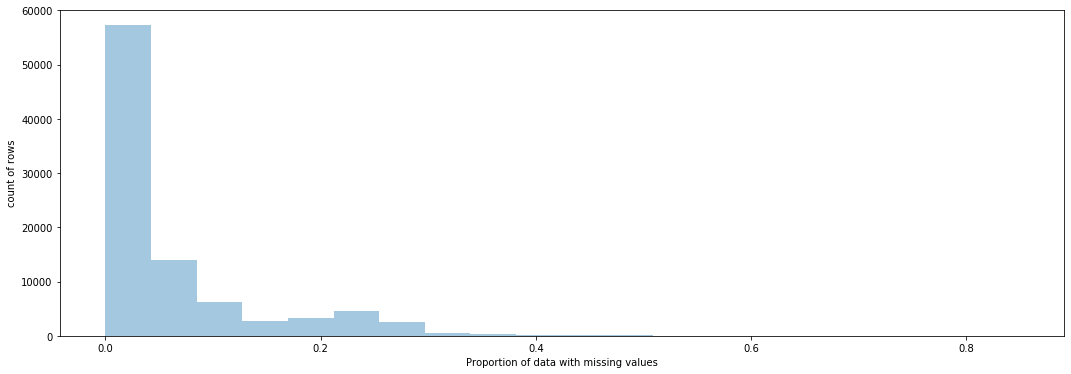

In [83]:
plt.figure(figsize=(18,6))

sns.distplot((training.isnull().sum(axis=1)/training.shape[1]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of rows')

In [92]:
training[(training.isnull().sum(axis=1)/training.shape[1])>0.2]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
19,45954,102946,118,0,39.0,37.010278,1,NaN,M,177.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
20,79115,88295,83,0,79.0,28.376100,1,Caucasian,F,170.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Neurological,Neurologic
50,31959,741,149,0,75.0,NaN,0,Caucasian,M,177.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91699,79858,57121,30,0,57.0,33.810548,0,African American,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
91700,103983,25454,30,0,85.0,25.091529,0,Caucasian,M,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
91705,111411,7848,195,0,67.0,28.876843,0,African American,M,182.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91707,276,34638,183,0,NaN,33.933518,0,Caucasian,F,152.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
rows_to_drop = training[(training.isnull().sum(axis=1)/training.shape[1])>0.2].index

In [96]:
training.drop(rows_to_drop, inplace=True)

In [98]:
import missingno as msno

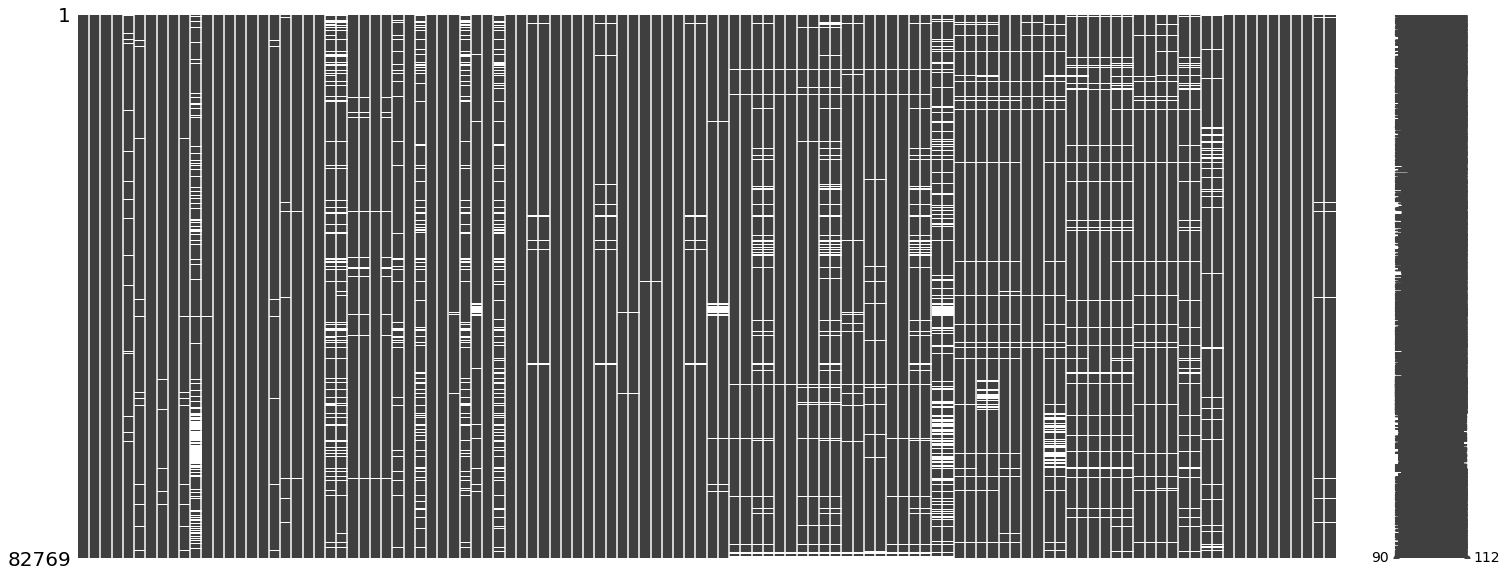

In [99]:
msno.matrix(training)